In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load


In [16]:
import warnings
warnings.filterwarnings('ignore')
SEED = 0
heart_data_orig = pd.read_csv('heart_failure_clinical_records_dataset.csv')
heart_data_prepro = heart_data_orig.copy()

################################################ Inspection of The Dataset ############################################
heart_data_prepro.info()
#No missing values in the data
#all columns are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [18]:
heart_data_prepro.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [20]:
heart_data_prepro.DEATH_EVENT

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

In [21]:
counts = heart_data_prepro['DEATH_EVENT'].value_counts()
print(f"Number of 0s (survived): {counts[0]}")
print(f"Number of 1s (death events): {counts[1]}")

Number of 0s (survived): 203
Number of 1s (death events): 96


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB




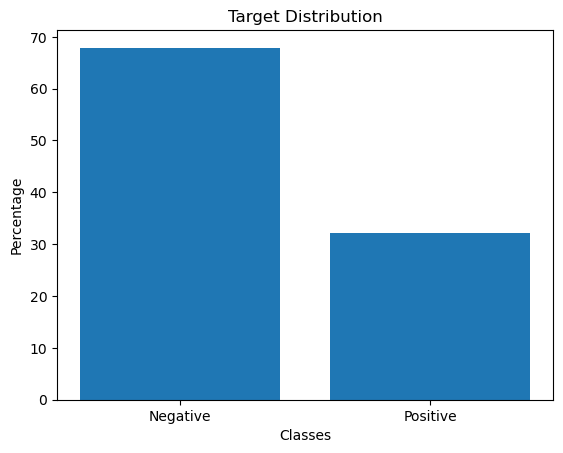

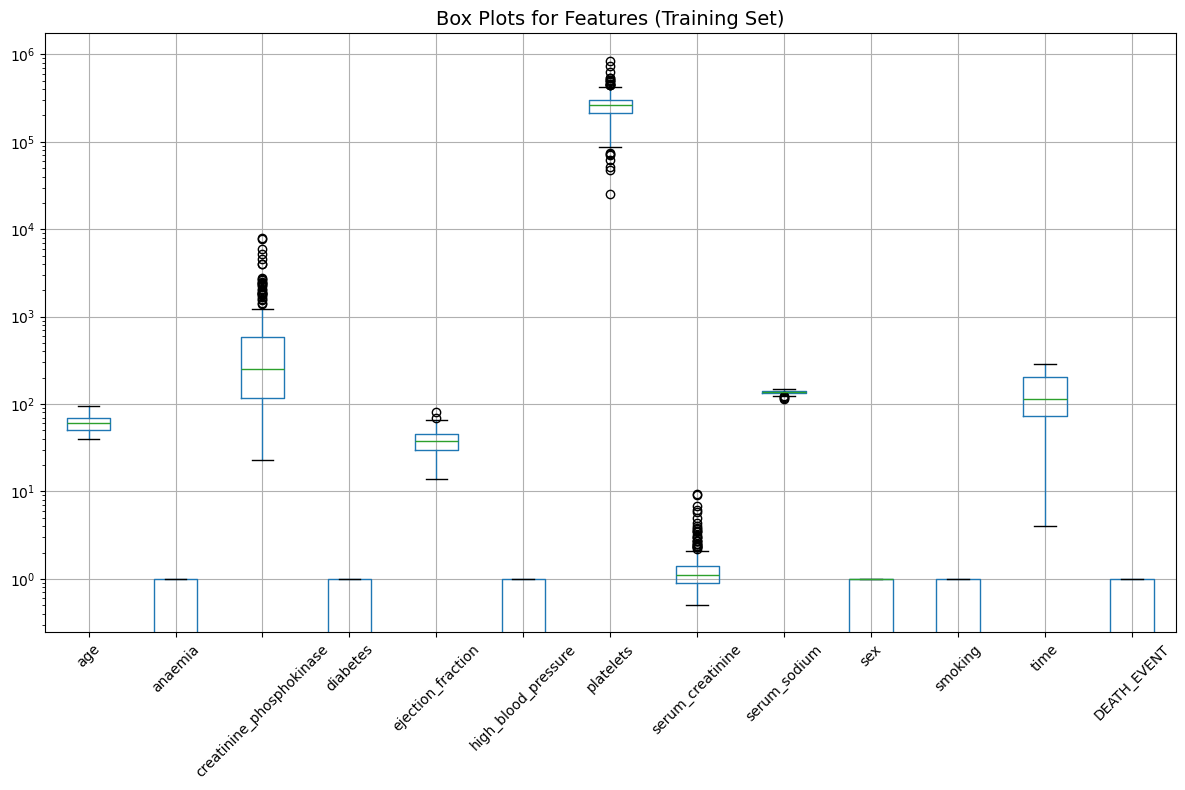

In [12]:
target_dist = heart_data_prepro["DEATH_EVENT"].value_counts()
percentage = (target_dist/ len(heart_data_prepro))*100

plt.figure()
plt.bar([0,1], percentage.values)
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel('Classes')
plt.ylabel('Percentage')
plt.title('Target Distribution')
plt.show()
#The positive group is the minority in the dataset - imbalanced dataset!

#visualizing the outliers - at this point, i will not change these values as random forests are suppose to be robust and capable
#of dealing with these values

plt.figure(figsize=(12, 8))
heart_data_prepro.boxplot()
plt.yscale('log')
plt.title('Box Plots for Features (Training Set)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:

#################################################### Preprocessing ###################################################
#First, splitting! Must be done first to prevent data leakage

class Preprocessor:
    def __init__(self, class_ratio=1.0, random_state=SEED):
        #class_ratio = minority_group / majority_group after applying SMOTE resampling
        self.class_ratio = class_ratio
        self.random_state = random_state

#Method to process only the train set: SMOTE to balance + Normalize with standardScaler
    def train_prepro(self, X_train, Y_train):
        sm = SMOTE(sampling_strategy=self.class_ratio, random_state=self.random_state)
        X_smote, Y_smote = sm.fit_resample(X_train, Y_train)

        self.scaler = StandardScaler()
        X_train_processed = self.scaler.fit_transform(X_smote)

        return X_train_processed, Y_smote

#Methof to process the test set: Only normalization, no SMOTE. We want to keep it natural with the imbalance
    def test_prepro(self, X_test):
    #We only transforming the test set using the fitted train set statistics
        if self.scaler is None:
            raise ValueError("Must call train_prepro first to fit the scaler!")

        X_test_processed = self.scaler.transform(X_test)
        return X_test_processed

Y = heart_data_prepro["DEATH_EVENT"]
X = heart_data_prepro.drop("DEATH_EVENT", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)


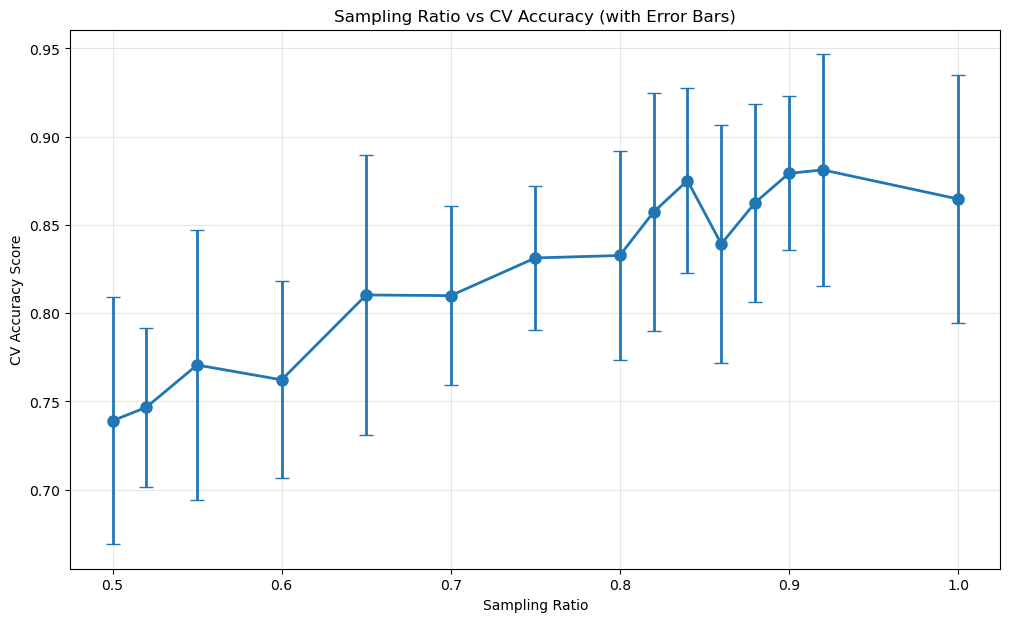

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Paramaters: 
{'max_depth': 42, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 145}

Threshold 0.2: Recall=0.947, Precision=0.581
Threshold 0.3: Recall=0.947, Precision=0.667
Threshold 0.35: Recall=0.895, Precision=0.708
Threshold 0.4: Recall=0.842, Precision=0.696
Threshold 0.45: Recall=0.842, Precision=0.696
Threshold 0.5: Recall=0.842, Precision=0.762

Results with threshold 0.5:


              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.76      0.84      0.80        19

    accuracy                           0.87        60
   macro avg       0.84      0.86      0.85        60
weighted avg       0.87      0.87      0.87        60



In [5]:
################################################ Train Base Models ################################################

#First, Finding a ratio for SMOTE. This ratio is deciding how much samples we will be adding syntheticaly,
#it's important to find the amount of synthetic samples that maximize the performance.
sampling_ratio = [0.5, 0.52, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 1.0]
results ={}
cv_means = []
cv_stds = []

for ratio in sampling_ratio:
    preprocessor = Preprocessor(class_ratio=ratio, random_state=SEED)
    x_train, y_train = preprocessor.train_prepro(X_train, Y_train)
    x_test = preprocessor.test_prepro(X_test)

    RF_model = RandomForestClassifier(random_state=SEED)
    cv_res = cross_val_score(RF_model, x_train, y_train, cv=5, scoring='f1')
    cv_means.append(cv_res.mean())
    cv_stds.append(cv_res.std())

# Plot with error bars
plt.figure(figsize=(12, 7))
plt.errorbar(sampling_ratio, cv_means, yerr=cv_stds,
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Sampling Ratio')
plt.ylabel('CV Accuracy Score')
plt.title('Sampling Ratio vs CV Accuracy (with Error Bars)')
plt.grid(True, alpha=0.3)
plt.show()

best_idx = np.argmax(cv_means)
best_ratio = sampling_ratio[best_idx]

#Now, training the final model with hyperparameter tuning
final_preprocessor = Preprocessor(class_ratio=best_ratio, random_state=SEED)
x_train_final, y_train_final = final_preprocessor.train_prepro(X_train, Y_train)
x_test_final = final_preprocessor.test_prepro(X_test)

param_dist = {
    'n_estimators': randint(20, 401),
    'max_depth': randint(20, 51),
    'min_samples_split': randint(2, 16),
    'min_samples_leaf': randint(2, 11),
    'max_features': ['sqrt', 'log2', 0.5]
}

RF_model = RandomForestClassifier(random_state=SEED)
randomsearch = RandomizedSearchCV(
    estimator=RF_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    random_state=42,
    verbose=1
)

randomsearch.fit(x_train_final, y_train_final)
best_model = randomsearch.best_estimator_
parameters = randomsearch.best_params_
print(f"Paramaters: \n{parameters}\n")

"""scores = randomsearch.best_score_

print(f"{scores:.4f}")
print(parameters)

y_pred = randomsearch.best_estimator_.predict(x_test_final)
print(classification_report(Y_test, y_pred))"""

#Get probabilities instead of predictions
y_proba_positive = best_model.predict_proba(x_test_final)[:, 1]

#Try different thresholds
thresholds = [0.2, 0.3, 0.35, 0.4, 0.45, 0.5]
F1_scores = {}
for threshold in thresholds:
    y_pred_thresh = (y_proba_positive >= threshold).astype(int)
    report = classification_report(Y_test, y_pred_thresh, output_dict=True)
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']
    F1_score1 = report['1']['f1-score']
    F1_scores[threshold] = F1_score1
    print(f"Threshold {threshold}: Recall={recall_class1:.3f}, Precision={precision_class1:.3f}")

#Final evaluation with the optimal value:
optimal_threshold = max(F1_scores, key=F1_scores.get)
y_proba = best_model.predict_proba(x_test_final)[:, 1]
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print(f"\nResults with threshold {optimal_threshold}:")
print("\n")
print(classification_report(Y_test, y_pred_optimal))

In [6]:
##################################################### Transfer Learning ###############################################

#Create Probabilites to the entire dataset
#x_train_processed = final_preprocessor.train_prepro(X_train, Y_train)
#x_test_processed = final_preprocessor.test_prepro(X_test)

x_train_copy = pd.DataFrame(x_train_final.copy())
x_test_copy = pd.DataFrame(x_test_final.copy())

train_proba_transfer = best_model.predict_proba(x_train_final)[:, 1]
test_proba_transfer = best_model.predict_proba(x_test_final)[:, 1]

transfer_column = ['proba_death']
prob_features_train = pd.DataFrame(train_proba_transfer, columns=transfer_column)
prob_features_test = pd.DataFrame(test_proba_transfer, columns=transfer_column)

X_train_transfered = pd.concat([x_train_copy.reset_index(drop=True), prob_features_train], axis=1)
X_test_transfered = pd.concat([x_test_copy.reset_index(drop=True), prob_features_test], axis=1)

#X_train_trans, X_test_trans, Y_train_trans, Y_test_trans = train_test_split(X_full_transfered, Y, test_size=0.2, random_state=SEED, stratify=Y)

In [7]:
############################################### Repeat With The Enhanced Dataset ###############################################


#First, Finding a ratio for SMOTE. This ratio is deciding how much samples we will be adding syntheticaly,
#it's important to find the amount of synthetic samples that maximize the performance.
#sampling_ratio = [0.5, 0.52, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 1.0]
#results ={}
#cv_means = []
#cv_stds = []

"""for ratio in sampling_ratio:
    preprocessor = Preprocessor(class_ratio=ratio, random_state=SEED)
    x_train, y_train = preprocessor.train_prepro(X_train_trans, Y_train_trans)
    x_test = preprocessor.test_prepro(X_test_trans)

    RF_model = RandomForestClassifier(random_state=SEED)
    cv_res = cross_val_score(RF_model, x_train, y_train, cv=5, scoring='f1')
    cv_means.append(cv_res.mean())
    cv_stds.append(cv_res.std())

# Plot with error bars
plt.figure(figsize=(12, 7))
plt.errorbar(sampling_ratio, cv_means, yerr=cv_stds,
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xlabel('Sampling Ratio')
plt.ylabel('CV Accuracy Score')
plt.title('Sampling Ratio vs CV Accuracy (with Error Bars)')
plt.grid(True, alpha=0.3)
plt.show()

best_idx = np.argmax(cv_means)
best_ratio = sampling_ratio[best_idx]

#Now, training the final model with hyperparameter tuning
final_preprocessor = Preprocessor(class_ratio=best_ratio, random_state=SEED)
x_train_final, y_train_final = final_preprocessor.train_prepro(X_train_transfered, Y_train_trans)
x_test_final = final_preprocessor.test_prepro(X_test_trans)"""

param_dist = {
    'n_estimators': randint(20, 401),
    'max_depth': randint(20, 51),
    'min_samples_split': randint(2, 16),
    'min_samples_leaf': randint(2, 11),
    'max_features': ['sqrt', 'log2', 0.5]
}

RF_model = RandomForestClassifier(random_state=SEED)
randomsearch = RandomizedSearchCV(
    estimator=RF_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    random_state=42,
    verbose=1
)

randomsearch.fit(X_train_transfered.to_numpy(), y_train_final)
best_model = randomsearch.best_estimator_
parameters = randomsearch.best_params_
print(f"Paramaters: \n{parameters}")

"""scores = randomsearch.best_score_

print(f"{scores:.4f}")
print(parameters)

y_pred = randomsearch.best_estimator_.predict(x_test_final)
print(classification_report(Y_test, y_pred))"""

#Get probabilities instead of predictions
y_proba_positive = best_model.predict_proba(X_test_transfered.to_numpy())[:, 1]

#Try different thresholds
thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]
F1_scores = {}
for threshold in thresholds:
    y_pred_thresh = (y_proba_positive >= threshold).astype(int)
    report = classification_report(Y_test, y_pred_thresh, output_dict=True)
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']
    F1_score1 = report['1']['f1-score']
    F1_scores[threshold] = F1_score1
    print(f"Threshold {threshold}: Recall={recall_class1:.3f}, Precision={precision_class1:.3f}")

#Final evaluation with the optimal value:
optimal_threshold = max(F1_scores, key=F1_scores.get)
y_proba = best_model.predict_proba(X_test_transfered.to_numpy())[:, 1]
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print(f"\nResults with threshold {optimal_threshold}:")
print("\n")
print(classification_report(Y_test, y_pred_optimal))

# After training the transfer learning model
feature_names = list(X.columns) + ['proba_death']
importance = best_model.feature_importances_

# Print feature importance
for name, imp in zip(feature_names, importance):
    print(f"{name}: {imp:.4f}")

# Check if probabilistic features dominate
prob_importance = importance[-1:].sum()  # Last feature
orig_importance = importance[:-1].sum()  # First 13 features
print(f"\nProbabilistic features importance: {prob_importance:.4f}")
print(f"Original features importance: {orig_importance:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Paramaters: 
{'max_depth': 34, 'max_features': 0.5, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 225}
Threshold 0.2: Recall=0.842, Precision=0.696
Threshold 0.25: Recall=0.842, Precision=0.696
Threshold 0.3: Recall=0.842, Precision=0.696
Threshold 0.35: Recall=0.789, Precision=0.714
Threshold 0.4: Recall=0.789, Precision=0.789

Results with threshold 0.4:


              precision    recall  f1-score   support

           0       0.90      0.90      0.90        41
           1       0.79      0.79      0.79        19

    accuracy                           0.87        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.87      0.87      0.87        60

age: 0.0074
anaemia: 0.0000
creatinine_phosphokinase: 0.0035
diabetes: 0.0003
ejection_fraction: 0.0355
high_blood_pressure: 0.0000
platelets: 0.0016
serum_creatinine: 0.0503
serum_sodium: 0.0064
sex: 0.0005
smoking: 0.0005
time: 0.1